In [2]:
# %pip install tensorflow_addons

In [3]:
import sys
sys.path.append("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/")

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, BatchNormalization, Concatenate
import numpy as np
import pandas as pd
import gc

/Users/tuanthanh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# import tensorflow_addons as tfa

In [6]:
from src.data import DataHelper
from src.data.metrics import map_at_k, recall_at_k, hr_at_k

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [8]:
from pathlib import Path
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [9]:
# * uncomment this when predicting testset to avoid GPU memory error
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [10]:
RANK_EMBEDDING_DIM = 64
BATCH_SIZE = 2**12
NEPOCH = 20

In [11]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"

In [12]:
data_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/data/HM")
model_dir = Path("/Users/tuanthanh/Documents/KLTN/SourceClone/H-M-Fashion-RecSys/models/models_HM")

In [13]:
dh = DataHelper(data_dir)
data = dh.load_data(name="encoded_full")

In [14]:
inter = data['inter']
inter = inter.loc[(inter.t_dat <= "2020-08-19")]

## Calculate & Load Embeddings

In [15]:
# article description - TFIDF - SVD
if not os.path.exists(data_dir/'external/tfidf_item_embd.npy'):
    articles = pd.read_csv(data_dir/'raw/articles.csv')

    corpus = articles[[col for col in articles.columns if 'name' in col] + ['detail_desc']].T.apply(lambda x: ' '.join(map(str,x))).T

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=256, random_state=0)
    tfidf_item = svd.fit_transform(X)
    tfidf_item = np.concatenate([np.ones((1,256)), tfidf_item], axis=0)
    tfidf_item.dump(data_dir/'external/tfidf_item_embd.npy')
else:
    tfidf_item = np.load(data_dir/'external/tfidf_item_embd.npy', allow_pickle=True)

In [16]:
# article_id - customer_id TFIDF + SVD
if not os.path.exists(data_dir/'external/tfidf_item_embd2.npy'):
    corpus = inter.groupby('article_id').customer_id.apply(lambda x: ' '.join(map(str, x)))
    article_ids = np.array(list(corpus.index))

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=128, random_state=0)
    X_svd = svd.fit_transform(X)

    item_num = data['item']['article_id'].nunique()
    tfidf_item2 = np.ones((item_num+1, 128)) / 128
    for i,iid in enumerate(article_ids):
        tfidf_item2[iid,:] = X_svd[i,:]

    tfidf_item2.dump(data_dir/'external/tfidf_item_embd2.npy')
else:
    tfidf_item2 = np.load(data_dir/'external/tfidf_item_embd2.npy', allow_pickle=True)

In [17]:
# customer_id - product_code TFIDF + SVD
if not os.path.exists(data_dir/'external/tfidf_user_embd.npy'):
    inter = inter.merge(data['item'][['article_id','product_code']], on=['article_id'], how='left')
    corpus = inter.groupby('customer_id').product_code.apply(lambda x: ' '.join(map(str, x)))
    customer_ids = np.array(list(corpus.index))

    vectorizer = TfidfVectorizer(min_df=3)
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=128, random_state=0)
    X_svd = svd.fit_transform(X)

    user_num = data['user']['customer_id'].nunique()
    tfidf_user = np.ones((user_num+1, 128)) / 128
    for i,uid in enumerate(customer_ids):
        tfidf_user[uid,:] = X_svd[i,:]

    tfidf_user.dump(data_dir/'external/tfidf_user_embd.npy')
else:
    tfidf_user = np.load(data_dir/'external/tfidf_user_embd.npy', allow_pickle=True)

In [18]:
# * Load pre-trained embeddings
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)
w2v_product_embd = np.load(data_dir/'external'/'w2v_product_embd.npy', allow_pickle=True)
image_item_embd = np.load(data_dir/'external'/'image_embd.npy', allow_pickle=True)
w2v_sg_user_embd = np.load(data_dir/'external'/'w2v_skipgram_user_embd.npy', allow_pickle=True)
w2v_sg_item_embd = np.load(data_dir/'external'/'w2v_skipgram_item_embd.npy', allow_pickle=True)
w2v_sg_product_embd = np.load(data_dir/'external'/'w2v_skipgram_product_embd.npy', allow_pickle=True)

## Load Candidates & Prepare Data

In [19]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    
    # Use whatever scoring column actually exists in your data
    if 'score' in candidates[i].columns:  # or 'final_score' or other column name
        candidates[i]['rank'] = candidates[i].groupby('customer_id')['score'].rank(ascending=False)
        candidates[i] = candidates[i][candidates[i]['rank'] <= 20]
    
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [00:06<00:00,  1.36s/it]


In [20]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "wv_similarity"
    ]
]

ids = ["customer_id", "article_id", "product_code"]
dense_feats = [x for x in feats if x not in ids]

In [21]:
def safe_convert_types(candidates, WEEK_NUM):
    for i in tqdm(range(1, WEEK_NUM), desc="Converting data types"):
        try:
            # Create a copy of columns to avoid modifying during iteration
            cols = list(candidates[i].columns)
            
            for col in cols:
                if candidates[i][col].dtype == 'float64':
                    candidates[i][col] = candidates[i][col].astype('float16')
                elif candidates[i][col].dtype == 'int64':
                    candidates[i][col] = candidates[i][col].astype('int16')
            
            # Force garbage collection after each week's processing
            gc.collect()
            
        except KeyboardInterrupt:
            print(f"\nConversion interrupted during week {i}. Saving progress...")
            break
        except Exception as e:
            print(f"Error converting types for week {i}, column {col}: {str(e)}")
            continue
    
    return candidates

In [22]:
def convert_in_chunks(df, column, chunk_size=1000000):
    chunks = []
    for i in range(0, len(df), chunk_size):
        chunk = df[column].iloc[i:i+chunk_size].astype('float16')
        chunks.append(chunk)
    return pd.concat(chunks)

for f in tqdm(dense_feats):
    for i in range(1, WEEK_NUM):
        if f in candidates[i].columns:
            candidates[i][f] = convert_in_chunks(candidates[i], f)
            gc.collect()

100%|██████████| 96/96 [01:02<00:00,  1.54it/s]


In [23]:
full_data = pd.concat([candidates[i] for i in range(1,WEEK_NUM)], ignore_index=True)

# =============================================
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")


tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

tmp = inter.groupby('customer_id').size()
full_data['customer_daily_bought'] = full_data['customer_id'].map(tmp) / full_data['customer_id_gap']

tmp = inter.groupby('customer_id').price.median()
full_data['customer_id_price_median'] = full_data['customer_id'].map(tmp)

full_data['customer_article_price_gap'] = full_data['customer_id_price_median'] - full_data['price']

del tmp
gc.collect()

from itertools import chain
def dict_union(L):
    return dict(chain.from_iterable(d.items() for d in L))

dur = [52]
for col in tqdm(["article_id","product_code"]):
    full_data[f'{col}_id_week'] = full_data[col].astype('str') + '_' + full_data['week'].astype('str')

    for j in dur:
        dict_list = []
        for i in range(5):
            tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
            
            tmp['week'] = i+1
            tmp = tmp.groupby(['week', col]).size().reset_index()
            tmp.columns = ['week', col, 'count_sales']

            tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

            dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
            del tmp

        dict_all = dict_union(dict_list)
        full_data[f'{col}_week_shift{j}'] = full_data[f'{col}_id_week'].map(dict_all)

        del dict_all
    gc.collect()


full_data['article_id_week_1/52'] = full_data['i_sale'] / full_data[f'article_id_week_shift52']
full_data['product_code_week_1/52'] = full_data['i_sale'] / full_data[f'product_code_week_shift52']

# =============================================
extra_feats = [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap',
    'customer_id_price_median',
    'customer_daily_bought',
    'customer_article_price_gap'
] + [f'{col}_week_shift{j}' for col in ["article_id","product_code"] for j in dur] +\
['article_id_week_1/52', 'product_code_week_1/52']
feats += extra_feats
dense_feats += extra_feats

for f in extra_feats:
    full_data[f] = full_data[f].astype('float16')

# =============================================

full_data = full_data[feats+['week','label']]
# full_data, _ = reduce_mem_usage(full_data)

100%|██████████| 2/2 [00:25<00:00, 12.51s/it]


In [24]:
gc.collect()
train = full_data[full_data['week']>1]
valid = full_data[full_data['week']==1]

In [25]:
del candidates
gc.collect()

0

In [26]:
feat_dim = {}
for feat in ids:
    if feat in data['user'].columns:
        feat_dim[feat] = int(data['user'][feat].max()) + 1
    elif feat in data['item'].columns:
        feat_dim[feat] = int(data['item'][feat].max()) + 1
    else:
        feat_dim[feat] = int(full_data[feat].max()) + 1

In [27]:
del full_data
gc.collect()

0

In [28]:
X_train1 = train[['customer_id', 'article_id', 'product_code']].values.astype('int32')
X_train2 = np.zeros((X_train1.shape[0], len(dense_feats)), dtype='float32')
for i,f in tqdm(enumerate(dense_feats)):
    X_train2[:, i] = np.nan_to_num(train[f].values).astype('float32')
    del train[f]
y_train = train['label'].values

108it [00:12,  8.63it/s]


In [29]:
X_test1 = valid[['customer_id', 'article_id', 'product_code']].values.astype('int32')
X_test2 = np.zeros((X_test1.shape[0], len(dense_feats)), dtype='float32')
for i,f in tqdm(enumerate(dense_feats)):
    X_test2[:, i] = np.nan_to_num(valid[f].values).astype('float32')
    del valid[f]
y_test = valid['label'].values

108it [00:04, 26.83it/s]


## Train Model

In [30]:
customer_embd_layer_1 = Embedding(
    feat_dim["customer_id"], 128, weights=[w2v_sg_user_embd], trainable=False
)
customer_embd_layer_2 = Embedding(
    feat_dim["customer_id"], 128, weights=[w2v_user_embd], trainable=False
)
customer_embd_layer_3 = Embedding(
    feat_dim["customer_id"], 128, weights=[tfidf_user], trainable=False
)

In [31]:
article_embd_layer_1 = Embedding(
    feat_dim["article_id"], 128, weights=[w2v_sg_item_embd], trainable=False
)

article_embd_layer_2 = Embedding(
    feat_dim["article_id"], 128, weights=[w2v_item_embd], trainable=False
)

article_embd_layer_3 = Embedding(
    feat_dim["article_id"], 256, weights=[tfidf_item], trainable=False
)

article_embd_layer_4 = Embedding(
    feat_dim["article_id"], 128, weights=[tfidf_item2], trainable=False
)

article_embd_layer_5 = Embedding(
    feat_dim["article_id"], 512, weights=[image_item_embd], trainable=False
)

In [32]:
product_embd_layer_1 = Embedding(
    feat_dim["product_code"], 128, weights=[w2v_sg_product_embd], trainable=False
)
product_embd_layer_2 = Embedding(
    feat_dim["product_code"], 128, weights=[w2v_product_embd], trainable=False
)

In [33]:
inputs1 = Input(shape=X_train1.shape[1:], dtype=tf.int64)
inputs2 = Input(shape=X_train2.shape[1:], dtype=tf.float32)

# Use Keras Lambda layer to perform the cast operation
input1 = tf.keras.layers.Lambda(lambda x: tf.cast(x, dtype=tf.int64))(inputs1)

x_c_id1 = customer_embd_layer_1(input1[:,0])
x_c_id2 = customer_embd_layer_2(input1[:,0])
x_c_id3 = customer_embd_layer_3(input1[:,0])

x_a_id1 = article_embd_layer_1(input1[:,1])
x_a_id2 = article_embd_layer_2(input1[:,1])
x_a_id3 = article_embd_layer_3(input1[:,1])
x_a_id3 = Dense(128)(x_a_id3)
x_a_id4 = article_embd_layer_4(input1[:,1])
x_a_id5 = article_embd_layer_5(input1[:,1])
x_a_id5 = Dense(128)(x_a_id5)

x_p_id1 = product_embd_layer_1(input1[:,2])
x_p_id2 = product_embd_layer_2(input1[:,2])

x_id = Concatenate(axis=-1)([
    x_c_id1, x_c_id2,
    x_a_id1, x_a_id2, x_a_id3, x_a_id4, x_a_id5,
    x_p_id1, x_p_id2,
])

x0 = Concatenate(axis=-1)([x_id, BatchNormalization()(inputs2)])

x = Dropout(0.3)(x0)
x = Dense(512, activation='swish')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='swish')(x)

x = Concatenate(axis=-1)([x, x0])
x = Dropout(0.3)(x)

output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=[output])
    
model.compile(
    tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=['AUC']
)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir/'large_nn.weights.h5',
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True)

history = model.fit(
    [X_train1, X_train2], y_train.astype(int), 
    shuffle=True,
    batch_size=2048,
    validation_data=([X_test1, X_test2], y_test.astype(int)),
    epochs=30,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 263s 54ms/step - AUC: 0.6659 - loss: 0.0407 - val_AUC: 0.4991 - val_loss: 0.6855
Epoch 2/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 264s 55ms/step - AUC: 0.7178 - loss: 0.0371 - val_AUC: 0.4991 - val_loss: 0.5091
Epoch 3/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 248s 52ms/step - AUC: 0.7259 - loss: 0.0369 - val_AUC: 0.4991 - val_loss: 0.2195
Epoch 4/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 269s 56ms/step - AUC: 0.7263 - loss: 0.0369 - val_AUC: 0.5024 - val_loss: 0.0621
Epoch 5/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 233s 49ms/step - AUC: 0.7300 - loss: 0.0369 - val_AUC: 0.4973 - val_loss: 0.0636
Epoch 6/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 222s 46ms/step - AUC: 0.7309 - loss: 0.0367 - val_AUC: 0.4983 - val_loss: 0.0603
Epoch 7/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 560s 117ms/step - AUC: 0.7312 - loss: 0.0367 - val_AUC: 0.5034 - val_loss: 0.0563
Epoch 8/30
4783/4783 ━━━━━━━━━━━━━━━━━━━━ 226s 47ms/step - AUC: 0.7341 - loss: 0.0367 - val_AUC: 0.5296 - val_loss: 0.0532
Epoch 9/30
4783

In [ ]:
print("Best model saved at:", checkpoint.best)

Best model saved at: -inf


In [ ]:
model.save(str(model_dir / 'large_nn.weights.keras'))  # Lưu mô hình thủ công sau khi huấn luyện

In [ ]:
model.load_weights(model_dir/'large_nn.weights.keras')

probs = model.predict([X_test1, X_test2], batch_size=4096)
label = data['inter'][data['inter']['t_dat']>='2020-09-16']
label = label.groupby('customer_id')['article_id'].apply(list).reset_index()

valid['prob'] = probs
pred = valid.sort_values(by='prob',ascending=False).reset_index(drop=True)
pred = pred.groupby('customer_id')['article_id'].apply(list).reset_index()
pred.columns = ['customer_id','prediction']

label = label.merge(pred, on='customer_id', how='left')

map_at_k(label['article_id'], label['prediction'], k=12)

745/745 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step


0.029407295472845037

In [ ]:
recall_at_k(label["article_id"], label["prediction"], k=12)

0.06771824353050777

In [ ]:
hr_at_k(label["article_id"], label["prediction"], k=12)

NameError: name 'hr_at_k' is not defined

In [ ]:
valid = valid[['customer_id','article_id','prob']]
valid.to_parquet(data_dir/'external'/'large_nn_valid.pqt')

## Test

In [ ]:
model.load_weights(model_dir/'large_nn.weights.keras')

In [ ]:
class TQDMPredictCallback(tf.keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

In [ ]:
del train, valid, X_train1, X_train2, X_test1, X_test2
gc.collect()

3688

In [ ]:
TEST_BATCH_NUM = 10

: 

In [ ]:
files = os.listdir(data_dir/"processed"/VERSION_NAME)
for batch in range(TEST_BATCH_NUM):
    chunk_files = [f for f in files if f.startswith(f"week0_candidate_{batch}")]
    for chunk,chunk_file in enumerate(sorted(chunk_files)):
        print(chunk_file)
        test_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/chunk_file)
        # test_candidate = test_candidate[test_candidate['rank']<=20].reset_index(drop=True)
         # Check and handle rank column
        if 'rank' not in test_candidate.columns:
                print(f"Warning: 'rank' column not found in {chunk_file}")
                
                # Try to create rank from available score columns
                score_cols = ['score', 'final_score', 'prediction_score']  # add possible score column names
                found_score = None
                
                for col in score_cols:
                    if col in test_candidate.columns:
                        found_score = col
                        break
                
                if found_score:
                    print(f"Creating rank from {found_score} column")
                    test_candidate['rank'] = test_candidate.groupby('customer_id')[found_score].rank(ascending=False)
                    test_candidate = test_candidate[test_candidate['rank'] <= 20].reset_index(drop=True)
                else:
                    print("No suitable score column found. Skipping rank filtering.")
        else:
                test_candidate = test_candidate[test_candidate['rank'] <= 20].reset_index(drop=True)
            
        # * ============================================================================================

        tmp = inter.groupby('article_id').week.mean()
        test_candidate['article_time_mean'] = test_candidate['article_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.nth(-1)
        test_candidate['customer_id_last_time'] = test_candidate['customer_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.nth(0)
        test_candidate['customer_id_first_time'] = test_candidate['customer_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.mean()
        test_candidate['customer_id_time_mean'] = test_candidate['customer_id'].map(tmp)

        test_candidate['customer_id_gap'] = test_candidate['customer_id_first_time'] - test_candidate['customer_id_last_time']

        tmp = inter.groupby('customer_id').size()
        test_candidate['customer_daily_bought'] = test_candidate['customer_id'].map(tmp) / test_candidate['customer_id_gap']

        tmp = inter.groupby('customer_id').price.median()
        test_candidate['customer_id_price_median'] = test_candidate['customer_id'].map(tmp)

        test_candidate['customer_article_price_gap'] = test_candidate['customer_id_price_median'] - test_candidate['price']

        del tmp
        gc.collect()

        from itertools import chain
        def dict_union(L):
            return dict(chain.from_iterable(d.items() for d in L))

        dur = [52]
        for col in tqdm(["article_id","product_code"]):
            test_candidate[f'{col}_id_week'] = test_candidate[col].astype('str') + '_' + test_candidate['week'].astype('str')

            for j in dur:
                dict_list = []
                for i in range(5):
                    tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
                    
                    tmp['week'] = i+1
                    tmp = tmp.groupby(['week', col]).size().reset_index()
                    tmp.columns = ['week', col, 'count_sales']

                    tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

                    dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
                    del tmp

                dict_all = dict_union(dict_list)
                test_candidate[f'{col}_week_shift{j}'] = test_candidate[f'{col}_id_week'].map(dict_all)

                del dict_all
            gc.collect()

        test_candidate['article_id_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'article_id_week_shift52']
        test_candidate['product_code_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'product_code_week_shift52']

        # * =================================================================================================================
        for f in tqdm(dense_feats):
            test_candidate[f] = test_candidate[f].astype('float16')
        
        test1 = test_candidate[['customer_id', 'article_id', 'product_code']].values.astype('int32')
        test2 = np.zeros((test1.shape[0], len(dense_feats)), dtype='float32')
        for i,f in tqdm(enumerate(dense_feats)):
            test2[:, i] = np.nan_to_num(test_candidate[f].values).astype('float32')
            del test_candidate[f]
        gc.collect()

        probs = model.predict([test1, test2], batch_size=2048, callbacks=[TQDMPredictCallback()])
        test_candidate["prob"] = probs
        pred_nn = test_candidate[['customer_id','article_id','prob']]
        # pred_nn.rename(columns={'article_id':'prediction'}, inplace=True)
        pred_nn['customer_id'] = pred_nn['customer_id'].astype(int)
        pred_nn.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_nn_test_{batch}_{chunk}.pqt")

week0_candidate_0.pqt
No suitable score column found. Skipping rank filtering.


100%|██████████| 108/108 [01:16<00:00,  1.42it/s]
108it [05:42,  3.17s/it]


---

In [ ]:
files = os.listdir(data_dir/"interim"/VERSION_NAME)
chunk_files = [f for f in files if f.startswith("large_nn_test_")]

In [ ]:
test_l = []
for f in tqdm(chunk_files):
    tmp_df = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f)
    test_l.append(tmp_df)

100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


In [ ]:
test_pred = pd.concat(test_l, ignore_index=True)

In [ ]:
test_pred['customer_id'].nunique()

685997

In [ ]:
test_pred.to_parquet(data_dir/"processed"/"large_nn_test.pqt")

<Axes: >

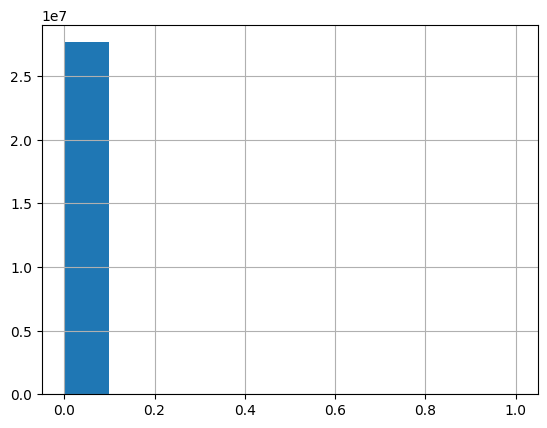

: 

In [ ]:
test_pred['prob'].hist()